In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from PIL import Image

import requests
from PIL import Image
import numpy as np
from io import BytesIO
import os

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd
import requests
import numpy as np
import librosa
from tqdm import tqdm
import os

from IPython.display import Audio


ModuleNotFoundError: No module named 'tensorflow.security'

In [2]:
bp_track = pd.read_csv('data/bp_track.csv')

C:\Users\Shank\AppData\Local\Temp\ipykernel_19744\1573399701.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  bp_track = pd.read_csv('data/bp_track.csv')


In [3]:
bp_track_media = pd.read_csv('data/bp_track_media.csv')

In [4]:
bp_genre = pd.read_csv('data/bp_genre.csv')

In [5]:
bp_genre.head()

,genre_id,genre_name,song_count,genre_url,updated_on
0,8,Hard Dance / Hardcore,178646,/genre/hard-dance-hardcore/8,2023-09-19 15:01:03
1,50,Nu Disco / Disco,157934,/genre/nu-disco-disco/50,2023-09-19 15:01:03
2,12,Deep House,897280,/genre/deep-house/12,2023-09-19 15:01:03
3,85,Bass / Club,20716,/genre/bass-club/85,2023-09-19 15:01:03
4,94,Electro (Classic / Detroit / Modern),19615,/genre/electro-classic-detroit-modern/94,2023-09-19 15:01:03


In [6]:
# Perform the merge to add only 'genre_id' from bp_track to bp_track_media
bp_media = pd.merge(bp_track_media, bp_track[['track_id', 'genre_id']], on='track_id', how='inner')

# Display the first few rows to verify
bp_media.head()

,track_id,wave_img_id,wave_img_uuid,sample_uuid,sample_start,sample_end,updated_on,genre_id
0,17767172,34401296.0,09d00050-0a43-42f1-bb6e-c22bf9591a80,09d00050-0a43-42f1-bb6e-c22bf9591a80,172732.0,292732.0,2023-09-14 16:19:56,99
1,17775434,34430784.0,b9509b0f-2b7d-4254-84df-cc53eded7904,b9509b0f-2b7d-4254-84df-cc53eded7904,163532.0,283532.0,2023-09-14 16:19:56,99
2,17800962,34520332.0,a9519a6a-a7cf-4a9e-aa55-b1b0ea80870b,a9519a6a-a7cf-4a9e-aa55-b1b0ea80870b,157108.0,277108.0,2023-09-14 16:19:56,99
3,17610335,33799612.0,93747c55-cfb1-4df5-9c6a-ce9f5751983f,93747c55-cfb1-4df5-9c6a-ce9f5751983f,162976.0,282976.0,2023-09-14 16:19:56,99
4,17610338,33799613.0,e104a0f7-dfb7-4e10-8ed3-056e018c9775,e104a0f7-dfb7-4e10-8ed3-056e018c9775,174826.0,294826.0,2023-09-14 16:19:56,99


In [7]:
# Assuming bp_media contains the genre_id and you want to replace it with genre_name

# Merge bp_media with bp_genre on 'genre_id'
bp_media = pd.merge(bp_media, bp_genre[['genre_id', 'genre_name']], on='genre_id', how='left')

# Optionally, drop 'genre_id' if you no longer need it
bp_media.drop('genre_id', axis=1, inplace=True)

In [8]:
sampled_data = bp_media.sample(n=1000, random_state=42)

In [9]:
import os
import requests
from tqdm import tqdm

def load_audio_from_url(df, sample_uuid_column, n_mfcc=13, max_length=200):
    audio_features = []
    failed_samples = []  # List to store IDs of failed audio downloads
    saved_file_paths = []  # List to collect the paths of saved audio files
    
    base_url = "https://geo-samples.beatport.com/track/"  # Base URL for audio files
    save_directory = "audio_files"  # Directory to save downloaded audio
    os.makedirs(save_directory, exist_ok=True)
    
    for sample_uuid in tqdm(df[sample_uuid_column]):
        # Construct full audio URL
        audio_url = f"{base_url}{sample_uuid}.LOFI.mp3"
        save_path = os.path.join(save_directory, f"{sample_uuid}.mp3")
        
        try:
            # Send a request to download the audio file
            response = requests.get(audio_url)
            response.raise_for_status()  # Raise an exception for failed requests

            # Save the downloaded audio file locally
            with open(save_path, 'wb') as f:
                f.write(response.content)
            
            # Append the file path to the saved file paths list
            saved_file_paths.append(save_path)
        
        except Exception as e:
            failed_samples.append(sample_uuid)  # Add the sample_uuid to the failed list
    
    return saved_file_paths, failed_samples

In [10]:
saved_file_paths, failed_sample_uuids = load_audio_from_url(sampled_data, 'sample_uuid')

100%|██████████| 1000/1000 [06:59<00:00,  2.38it/s]


In [11]:
# Function to extract MFCCs from an audio file
def extract_mfcc(audio_file_path, n_mfcc=13, max_length=200):
    try:
        # Load the audio file using librosa
        signal, sample_rate = librosa.load(audio_file_path, sr=None)

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc)

        # Pad or truncate MFCCs to a fixed length
        if mfccs.shape[1] < max_length:
            mfccs_padded = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
        else:
            mfccs_padded = mfccs[:, :max_length]

        return mfccs_padded
    
    except Exception as e:
        print(f"Error processing audio file {audio_file_path}: {e}")
        return None

In [12]:
# Initialize lists to hold MFCC features and genres
mfcc_features = []
genres = []

# Iterate over all saved audio files (from the load_audio_from_url function)
for audio_file_path in tqdm(saved_file_paths):
    # Extract the sample_uuid from the file path (assuming the file name is in the form 'sample_uuid.mp3')
    sample_uuid = os.path.basename(audio_file_path).replace('.mp3', '')  # Extract just the sample_uuid

    # Find the corresponding genre in the DataFrame
    genre = sampled_data.loc[sampled_data['sample_uuid'] == sample_uuid, 'genre_name'].values
    if len(genre) == 0:
        print(f"Genre not found for {sample_uuid}, skipping.")
        continue

    genre = genre[0]  # Extract the genre value

    # Extract MFCC features
    mfccs = extract_mfcc(audio_file_path)

    # Only append if MFCC extraction was successful
    if mfccs is not None:
        mfcc_features.append(mfccs)  # Append MFCC features
        genres.append(genre)  # Append the corresponding genre

# Convert the lists of MFCC features and genres into NumPy arrays
mfcc_features = np.array(mfcc_features)
genres = np.array(genres)

print(f"Extracted MFCC features shape: {mfcc_features.shape}")
print(f"Genre labels shape: {genres.shape}")

100%|██████████| 994/994 [08:39<00:00,  1.91it/s] 


Extracted MFCC features shape: (994, 13, 200)
Genre labels shape: (994,)


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# 1. Normalize the MFCC features
scaler = StandardScaler()

# Reshape the MFCC features to 2D array for scaling (before reshaping back)
mfcc_reshaped = mfcc_features.reshape(mfcc_features.shape[0], -1)

# Fit the scaler to the data and transform it
mfcc_normalized = scaler.fit_transform(mfcc_reshaped)

# Reshape back to the original shape after scaling
mfcc_normalized = mfcc_normalized.reshape(mfcc_features.shape)

# 2. Convert genre labels to numerical format (if they are strings)
# This step assumes that genres are strings. If they are already numbers, you can skip it.
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
genres_encoded = label_encoder.fit_transform(genres)

# One-hot encode the genres for the classification task
genres_one_hot = to_categorical(genres_encoded)

# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    mfcc_normalized, genres_one_hot, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (795, 13, 200), (795, 30)
Test set shape: (199, 13, 200), (199, 30)


In [14]:
# Reshape MFCC features for the CNN (add a channel dimension)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Number of genres (output classes)
num_classes = y_train.shape[1]

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(num_classes, activation='softmax')  # Output layer with softmax for classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 11, 198, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 99, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 97, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 48, 64)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               3

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define the path where the best model will be saved
model_checkpoint_path = 'best_model_audio.h5'

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)
model_checkpoint = ModelCheckpoint(model_checkpoint_path, monitor='val_loss', save_best_only=True)

# Train the model with the callbacks
history = model.fit(X_train_cnn, y_train, epochs=100, batch_size=15, validation_data=(X_test_cnn, y_test), callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Evaluate the best model on the test data
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")


Epoch 1/100
53/53 [==============================] - 4s 45ms/step - loss: 3.1166 - accuracy: 0.0969 - val_loss: 2.9469 - val_accuracy: 0.1206 - lr: 0.0010
Epoch 2/100
53/53 [==============================] - 2s 29ms/step - loss: 2.9730 - accuracy: 0.1384 - val_loss: 2.8861 - val_accuracy: 0.1407 - lr: 0.0010
Epoch 3/100
53/53 [==============================] - 1s 27ms/step - loss: 2.8590 - accuracy: 0.1447 - val_loss: 2.9376 - val_accuracy: 0.1558 - lr: 0.0010
Epoch 4/100
53/53 [==============================] - 1s 24ms/step - loss: 2.8004 - accuracy: 0.1623 - val_loss: 2.9159 - val_accuracy: 0.0955 - lr: 0.0010
Epoch 5/100
53/53 [==============================] - 1s 25ms/step - loss: 2.7329 - accuracy: 0.2025 - val_loss: 2.9352 - val_accuracy: 0.1508 - lr: 0.0010
Epoch 6/100
53/53 [==============================] - 1s 28ms/step - loss: 2.6487 - accuracy: 0.2302 - val_loss: 2.8800 - val_accuracy: 0.1558 - lr: 0.0010
Epoch 7/100
53/53 [==============================] - 1s 23ms/step - lo

_________

# Manual Grouping

In [16]:
genre_mapping = {
    # House Group
    'House': 'House',
    'Tech House': 'House',
    'Deep House': 'House',
    'Progressive House': 'House',
    'Funky House': 'House',
    'Jackin House': 'House',
    'Afro House': 'House',
    'Bass House': 'House',

    # Techno Group
    'Techno (Peak Time / Driving)': 'Techno',
    'Techno (Raw / Deep / Hypnotic)': 'Techno',
    'Minimal / Deep Tech': 'Techno',
    'Melodic House & Techno': 'Techno',
    'Hard Techno': 'Techno',

    # Trance Group
    'Trance (Main Floor)': 'Trance',
    'Psy-Trance': 'Trance',
    'Trance (Raw / Deep / Hypnotic)': 'Trance',

    # Bass Music Group
    'Drum & Bass': 'Bass Music',
    'Dubstep': 'Bass Music',
    '140 / Deep Dubstep / Grime': 'Bass Music',
    'Trap / Wave': 'Bass Music',
    'Breaks / Breakbeat / UK Bass': 'Bass Music',
    'Bass / Club': 'Bass Music',
    'UK Garage / Bassline': 'Bass Music',

    # Hard Dance & Hardcore Group
    'Hard Dance / Hardcore': 'Hard Dance & Hardcore',

    # Dance/Pop Group
    'Mainstage': 'Dance/Pop',
    'Dance / Electro Pop': 'Dance/Pop',
    'Nu Disco / Disco': 'Dance/Pop',

    # Downtempo & World Group
    'Organic House / Downtempo': 'Downtempo & World',
    'Amapiano': 'Downtempo & World',

    # Experimental & Indie Group
    'Electronica': 'Experimental & Indie',
    'Indie Dance': 'Experimental & Indie',
    'Electro (Classic / Detroit / Modern)': 'Experimental & Indie'
}


In [17]:
# Assuming your DataFrame is df and it has a column 'genre_name'
bp_genre['broad_genre'] = bp_genre['genre_name'].map(genre_mapping)

# Check the result
print(bp_genre[['genre_name', 'broad_genre']])

                              genre_name            broad_genre
0                  Hard Dance / Hardcore  Hard Dance & Hardcore
1                       Nu Disco / Disco              Dance/Pop
2                             Deep House                  House
3                            Bass / Club             Bass Music
4   Electro (Classic / Detroit / Modern)   Experimental & Indie
5                            Hard Techno                 Techno
6                                Dubstep             Bass Music
7             140 / Deep Dubstep / Grime             Bass Music
8                            Funky House                  House
9                      Progressive House                  House
10             Organic House / Downtempo      Downtempo & World
11                           Indie Dance   Experimental & Indie
12                            Afro House                  House
13                   Minimal / Deep Tech                 Techno
14                             Mainstage

In [18]:
# Perform the merge to add only 'genre_id' from bp_track to bp_track_media
bp_media = pd.merge(bp_track_media, bp_track[['track_id', 'genre_id']], on='track_id', how='inner')

In [19]:
# Merge bp_media with bp_genre on 'genre_id'
bp_media = pd.merge(bp_media, bp_genre[['genre_id', 'broad_genre']], on='genre_id', how='left')

# Optionally, drop 'genre_id' if you no longer need it
bp_media.drop('genre_id', axis=1, inplace=True)

In [20]:
sampled_data = bp_media.sample(n=1000, random_state=42)

In [21]:
# Initialize lists to hold MFCC features and genres
mfcc_features = []
genres = []

# Iterate over all saved audio files (from the load_audio_from_url function)
for audio_file_path in tqdm(saved_file_paths):
    # Extract the sample_uuid from the file path (assuming the file name is in the form 'sample_uuid.mp3')
    sample_uuid = os.path.basename(audio_file_path).replace('.mp3', '')  # Extract just the sample_uuid

    # Find the corresponding genre in the DataFrame
    genre = sampled_data.loc[sampled_data['sample_uuid'] == sample_uuid, 'broad_genre'].values
    if len(genre) == 0:
        print(f"Genre not found for {sample_uuid}, skipping.")
        continue

    genre = genre[0]  # Extract the genre value

    # Extract MFCC features
    mfccs = extract_mfcc(audio_file_path)

    # Only append if MFCC extraction was successful
    if mfccs is not None:
        mfcc_features.append(mfccs)  # Append MFCC features
        genres.append(genre)  # Append the corresponding genre

# Convert the lists of MFCC features and genres into NumPy arrays
mfcc_features = np.array(mfcc_features)
genres = np.array(genres)

print(f"Extracted MFCC features shape: {mfcc_features.shape}")
print(f"Genre labels shape: {genres.shape}")


100%|██████████| 994/994 [07:35<00:00,  2.18it/s]


Extracted MFCC features shape: (994, 13, 200)
Genre labels shape: (994,)


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# 1. Normalize the MFCC features
scaler = StandardScaler()

# Reshape the MFCC features to 2D array for scaling (before reshaping back)
mfcc_reshaped = mfcc_features.reshape(mfcc_features.shape[0], -1)

# Fit the scaler to the data and transform it
mfcc_normalized = scaler.fit_transform(mfcc_reshaped)

# Reshape back to the original shape after scaling
mfcc_normalized = mfcc_normalized.reshape(mfcc_features.shape)

In [23]:
# 2. Convert genre labels to numerical format (if they are strings)
# This step assumes that genres are strings. If they are already numbers, you can skip it.
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
genres_encoded = label_encoder.fit_transform(genres)

# One-hot encode the genres for the classification task
genres_one_hot = to_categorical(genres_encoded)

# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    mfcc_normalized, genres_one_hot, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (795, 13, 200), (795, 8)
Test set shape: (199, 13, 200), (199, 8)


In [24]:
# Reshape MFCC features for the CNN (add a channel dimension)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Number of genres (output classes)
num_classes = y_train.shape[1]

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(num_classes, activation='softmax')  # Output layer with softmax for classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 11, 198, 32)       320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 99, 32)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 97, 64)         18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 48, 64)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define the path where the best model will be saved
model_checkpoint_path = 'best_model_audio.h5'

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)
model_checkpoint = ModelCheckpoint(model_checkpoint_path, monitor='val_loss', save_best_only=True)

# Train the model with the callbacks
history = model.fit(X_train_cnn, y_train, epochs=100, batch_size=15, validation_data=(X_test_cnn, y_test), callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Evaluate the best model on the test data
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")


Epoch 1/100
53/53 [==============================] - 3s 46ms/step - loss: 1.8321 - accuracy: 0.3019 - val_loss: 1.7426 - val_accuracy: 0.3618 - lr: 0.0010
Epoch 2/100
53/53 [==============================] - 2s 40ms/step - loss: 1.7384 - accuracy: 0.3371 - val_loss: 1.7153 - val_accuracy: 0.3568 - lr: 0.0010
Epoch 3/100
53/53 [==============================] - 3s 51ms/step - loss: 1.6736 - accuracy: 0.3623 - val_loss: 1.6962 - val_accuracy: 0.3568 - lr: 0.0010
Epoch 4/100
53/53 [==============================] - 2s 47ms/step - loss: 1.6229 - accuracy: 0.3786 - val_loss: 1.7305 - val_accuracy: 0.3518 - lr: 0.0010
Epoch 5/100
53/53 [==============================] - 2s 45ms/step - loss: 1.6051 - accuracy: 0.3736 - val_loss: 1.7131 - val_accuracy: 0.3518 - lr: 0.0010
Epoch 6/100
53/53 [==============================] - 2s 47ms/step - loss: 1.5433 - accuracy: 0.3899 - val_loss: 1.7192 - val_accuracy: 0.3518 - lr: 0.0010
Epoch 7/100
53/53 [==============================] - 3s 48ms/step - lo

______________

# KMeans Clustering

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [27]:
sampled_data = bp_media.sample(n=1000, random_state=42)

saved_file_paths, failed_samples_uuids = load_audio_from_url(sampled_data, 'sample_uuid')

100%|██████████| 1000/1000 [05:19<00:00,  3.13it/s]


In [28]:
def extract_mfcc(audio_file_path, n_mfcc=13, max_length=200):
    try:
        # Load the audio file using librosa
        signal, sample_rate = librosa.load(audio_file_path, sr=None)

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc)

        # Pad or truncate MFCC to a fixed length
        if mfccs.shape[1] < max_length:
            mfccs_padded = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
        else:
            mfccs_padded = mfccs[:, :max_length]
        
        # Flatten the MFCCs to 1D
        return mfccs_padded.flatten()

    except Exception as e:
        print(f"Error processing audio file {audio_file_path}: {e}")
        return None

In [29]:
features_list = []
for audio_file_path in saved_file_paths:
    mfcc_features = extract_mfcc(audio_file_path)  # Using your extract_mfcc function
    features_list.append(mfcc_features)

# Convert features list to a numpy array for clustering
features_list = np.array(features_list)

KeyboardInterrupt: 

In [30]:
scaler = StandardScaler()
features_list_scaled = scaler.fit_transform(features_list)

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMe

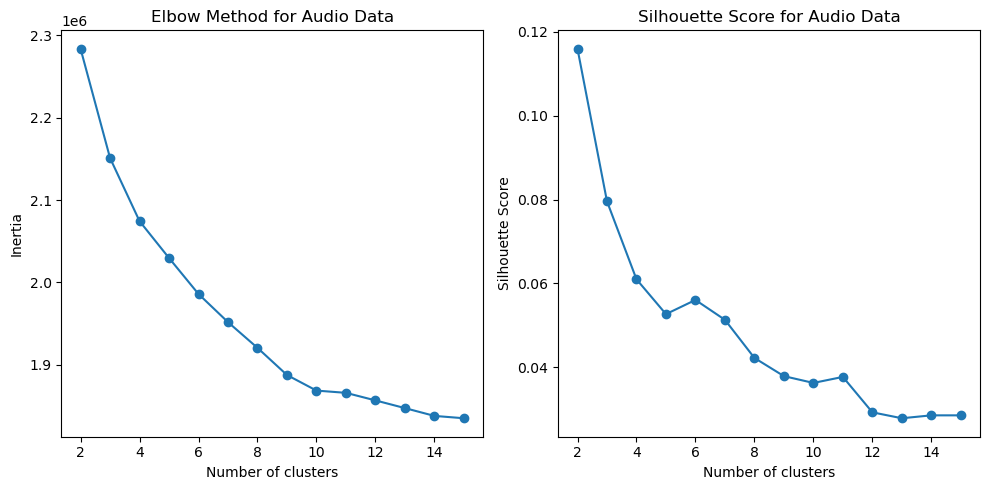

In [31]:
inertia = []
sil_scores = []
cluster_range = range(2, 16)  # Test 2 to 15 clusters

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_list_scaled)
    
    # Append the inertia for Elbow Method
    inertia.append(kmeans.inertia_)
    
    # Predict cluster labels and calculate silhouette score
    cluster_labels = kmeans.predict(features_list_scaled)
    sil_score = silhouette_score(features_list_scaled, cluster_labels)
    sil_scores.append(sil_score)

# Step 5: Plot Elbow Method and Silhouette Scores
plt.figure(figsize=(10, 5))

# Elbow Method
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Audio Data')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(cluster_range, sil_scores, marker='o')
plt.title('Silhouette Score for Audio Data')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


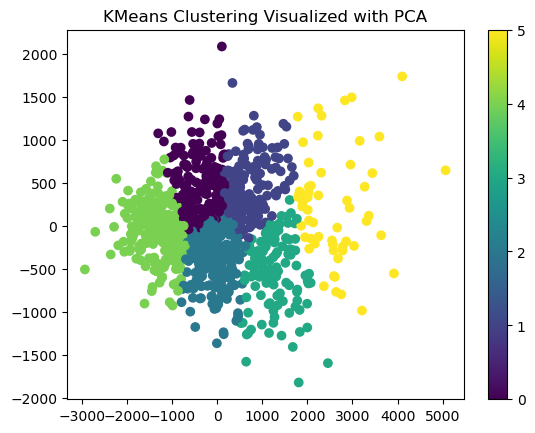

In [32]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_list)

# Apply KMeans on the original feature list
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(features_list)

# Now visualize in 2D after PCA
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('KMeans Clustering Visualized with PCA')
plt.show()

________

# DBSCAN Clustering

In [33]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_list_scaled)

In [34]:
from sklearn.cluster import DBSCAN

# Assuming you've chosen an appropriate value for `eps`
dbscan = DBSCAN(eps=5, min_samples=5)  # Tune min_samples based on your data
dbscan_clusters = dbscan.fit_predict(features_pca)

# Check how many clusters and how many outliers (noise points)
n_clusters = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)
n_noise = list(dbscan_clusters).count(-1)
print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

Estimated number of clusters: 4
Estimated number of noise points: 86


In [35]:
# Filter out noise points for silhouette score (-1 represents noise)
if n_clusters > 1:
    valid_clusters = dbscan_clusters[dbscan_clusters != -1]
    valid_features = features_pca[dbscan_clusters != -1]

    sil_score = silhouette_score(valid_features, valid_clusters)
    print(f'Silhouette Score for DBSCAN: {sil_score}')
else:
    print("Not enough clusters for Silhouette Score")

Silhouette Score for DBSCAN: 0.3159841001033783


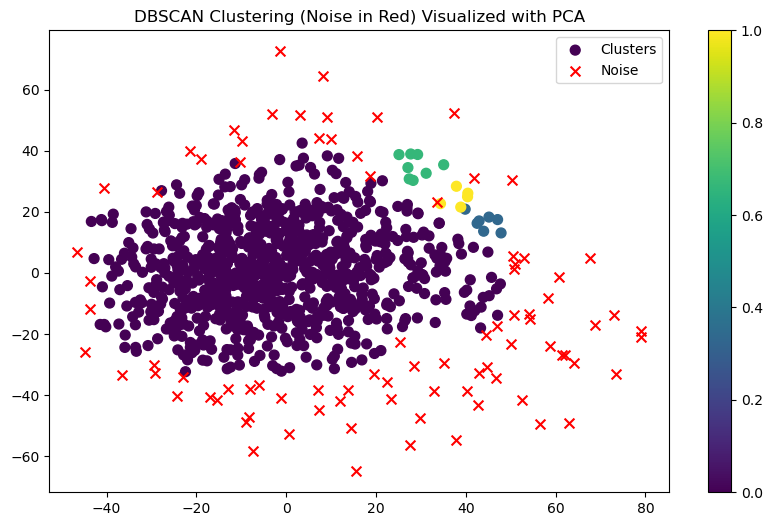

In [36]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=5, min_samples=5)  # Adjust 'eps' and 'min_samples' as needed
dbscan_clusters = dbscan.fit_predict(features_pca)

# Separate the noise (cluster -1) from the other clusters
core_samples_mask = dbscan_clusters != -1
noise_samples_mask = dbscan_clusters == -1

# Plot core clusters
plt.figure(figsize=(10, 6))
plt.scatter(features_pca[core_samples_mask, 0], features_pca[core_samples_mask, 1], 
            c=dbscan_clusters[core_samples_mask], cmap='viridis', s=50, label='Clusters')

# Plot noise samples
plt.scatter(features_pca[noise_samples_mask, 0], features_pca[noise_samples_mask, 1], 
            c='red', s=50, label='Noise', marker='x')

plt.colorbar()
plt.legend()
plt.title('DBSCAN Clustering (Noise in Red) Visualized with PCA')
plt.show()

_____________

# Agglomerative Clustering

In [37]:
from sklearn.cluster import AgglomerativeClustering

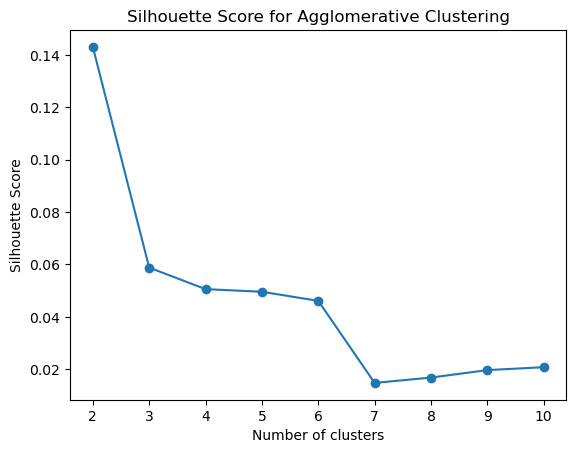

In [38]:
# List to store silhouette scores for different number of clusters
sil_scores = []

# Range of cluster numbers to test
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    agglo_clusters = agglo.fit_predict(features_list_scaled)
    
    # Calculate the silhouette score
    sil_score = silhouette_score(features_list_scaled, agglo_clusters)
    sil_scores.append(sil_score)

# Plot the silhouette scores for different cluster numbers
plt.plot(cluster_range, sil_scores, marker='o')
plt.title('Silhouette Score for Agglomerative Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

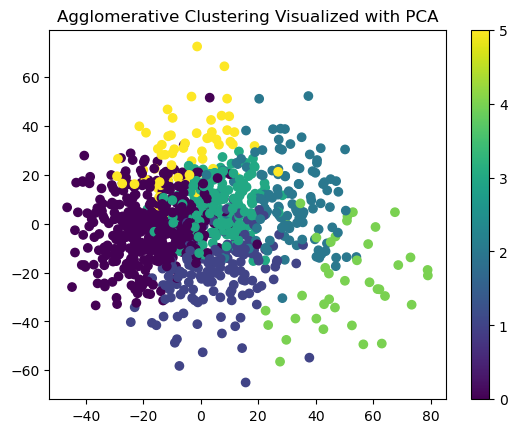

In [39]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_list_scaled)

# Apply KMeans on the original feature list
agglo = AgglomerativeClustering(n_clusters=6)
clusters = agglo.fit_predict(features_list_scaled)

# Now visualize in 2D after PCA
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('Agglomerative Clustering Visualized with PCA')
plt.show()

________

# GMM Clustering

In [40]:
from sklearn.mixture import GaussianMixture

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMe

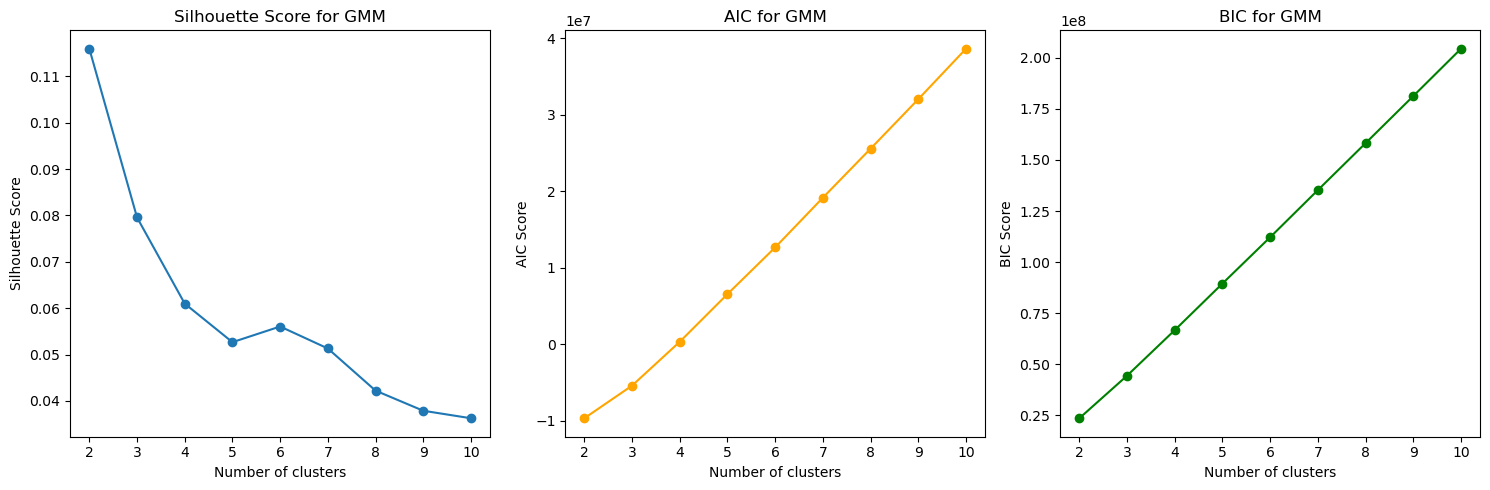

In [41]:
# Lists to store scores for different numbers of clusters
sil_scores = []
aic_scores = []
bic_scores = []

# Range of cluster numbers to test
cluster_range = range(2, 11)  # Try different numbers of clusters

for n_clusters in cluster_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    
    # Fit the GMM model
    gmm_clusters = gmm.fit_predict(features_list_scaled)
    
    # Calculate and append the silhouette score
    sil_score = silhouette_score(features_list_scaled, gmm_clusters)
    sil_scores.append(sil_score)
    
    # Append AIC and BIC scores
    aic_scores.append(gmm.aic(features_list_scaled))
    bic_scores.append(gmm.bic(features_list_scaled))

# Plot the results
plt.figure(figsize=(15, 5))

# Plot Silhouette Scores
plt.subplot(1, 3, 1)
plt.plot(cluster_range, sil_scores, marker='o')
plt.title('Silhouette Score for GMM')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

# Plot AIC Scores
plt.subplot(1, 3, 2)
plt.plot(cluster_range, aic_scores, marker='o', label='AIC', color='orange')
plt.title('AIC for GMM')
plt.xlabel('Number of clusters')
plt.ylabel('AIC Score')

# Plot BIC Scores
plt.subplot(1, 3, 3)
plt.plot(cluster_range, bic_scores, marker='o', label='BIC', color='green')
plt.title('BIC for GMM')
plt.xlabel('Number of clusters')
plt.ylabel('BIC Score')

plt.tight_layout()
plt.show()

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


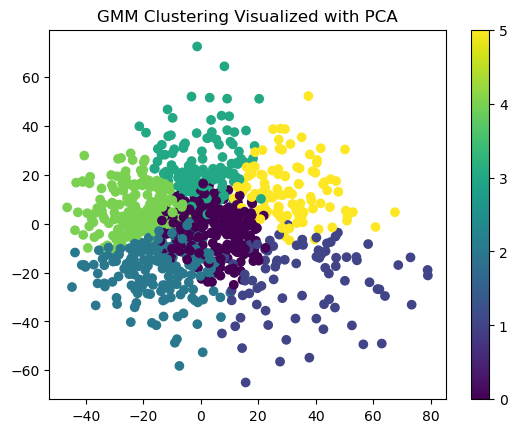

In [50]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_list_scaled)

# Apply KMeans on the original feature list
gmm = GaussianMixture(n_components=6)
clusters = gmm.fit_predict(features_list_scaled)

# Now visualize in 2D after PCA
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('GMM Clustering Visualized with PCA')
plt.show()

______

# Spectral Clustering

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\Shank\anaconda3\env

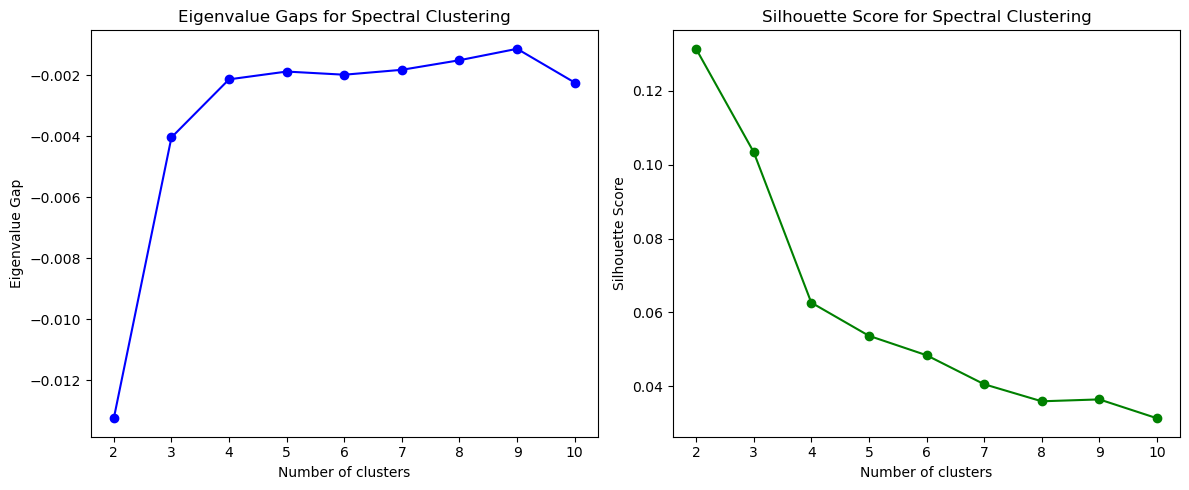

In [43]:
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import spectral_embedding

# Define a function to calculate eigenvalue gap
def calculate_eigenvalue_gaps(features_list_scaled, cluster_range):
    eigenvalue_gaps = []
    
    for n_clusters in cluster_range:
        # Create the affinity matrix using k-nearest neighbors graph
        affinity_matrix = kneighbors_graph(features_list_scaled, n_neighbors=10).toarray()
        
        # Compute the spectral embedding (eigenvalues of Laplacian matrix)
        embedding = spectral_embedding(affinity_matrix, n_components=n_clusters)
        eigenvalues = np.linalg.svd(embedding, compute_uv=False)  # Get singular values (eigenvalues)
        
        # Compute the eigenvalue gaps
        eigenvalue_gaps.append(np.diff(eigenvalues).max())  # Largest gap between consecutive eigenvalues
    
    return eigenvalue_gaps

# List to store silhouette scores for different number of clusters
sil_scores = []

# Range of cluster numbers to test
cluster_range = range(2, 11)

# Calculate the eigenvalue gaps
eigenvalue_gaps = calculate_eigenvalue_gaps(features_list_scaled, cluster_range)

# Perform spectral clustering and calculate silhouette scores
for n_clusters in cluster_range:
    # Apply Spectral Clustering
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
    cluster_labels = spectral.fit_predict(features_list_scaled)
    
    # Calculate silhouette score
    sil_score = silhouette_score(features_list_scaled, cluster_labels)
    sil_scores.append(sil_score)

# Plot the eigenvalue gaps and silhouette scores side by side
plt.figure(figsize=(12, 5))

# Plot Eigenvalue Gaps
plt.subplot(1, 2, 1)
plt.plot(cluster_range, eigenvalue_gaps, marker='o', color='blue')
plt.title('Eigenvalue Gaps for Spectral Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Eigenvalue Gap')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(cluster_range, sil_scores, marker='o', color='green')
plt.title('Silhouette Score for Spectral Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


In [44]:
# Apply Clustering on the original feature list
spectral = SpectralClustering(n_components=5)
clusters = spectral.fit_predict(features_list_scaled)

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


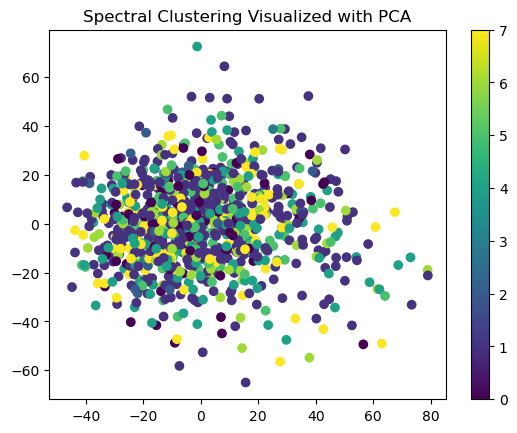

In [45]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_list_scaled)

# Now visualize in 2D after PCA
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('Spectral Clustering Visualized with PCA')
plt.show()

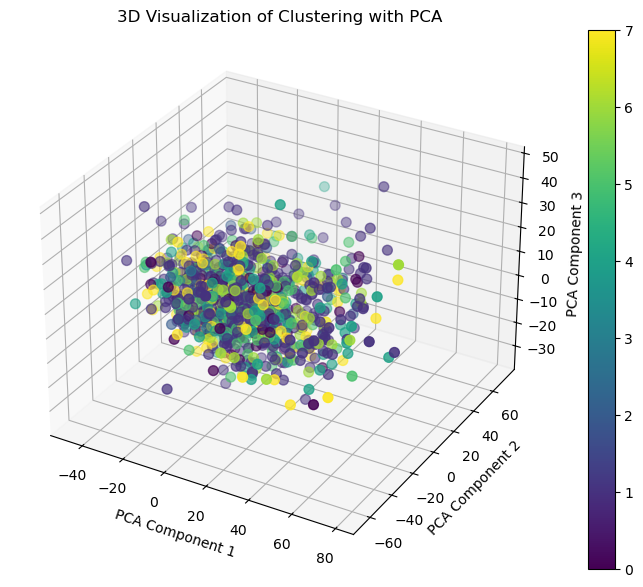

In [46]:
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_list_scaled)

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the PCA-reduced data in 3D with cluster labels as color
scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], 
                     c=clusters, cmap='viridis', s=50)

# Add a colorbar
plt.colorbar(scatter)

# Set labels and title
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('3D Visualization of Clustering with PCA')

# Show plot
plt.show()

______

# Mean Shift Clustering

In [47]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Estimate bandwidth for MeanShift algorithm
bandwidth = estimate_bandwidth(features_list_scaled, quantile=0.0001, n_samples=500)

# Apply Mean Shift clustering
mean_shift = MeanShift(bandwidth=24, bin_seeding=True)
mean_shift_clusters = mean_shift.fit_predict(features_list_scaled)

# Print the number of clusters found
n_clusters = len(np.unique(mean_shift_clusters))
print(f'Number of clusters found: {n_clusters}')

Number of clusters found: 1


In [48]:
# sil_score = silhouette_score(features_list_scaled, mean_shift_clusters)
# print(f'Silhouette Score for Mean Shift: {sil_score}')

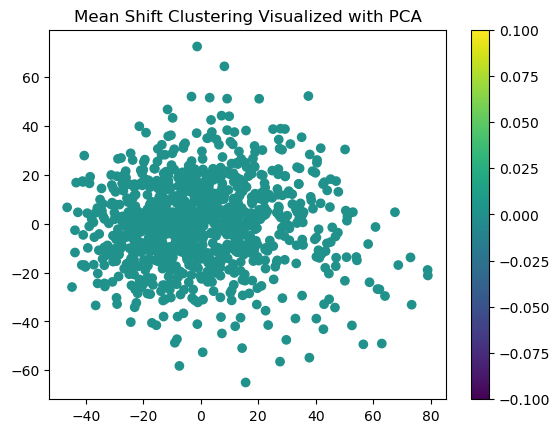

In [49]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_list_scaled)

# Now visualize in 2D after PCA
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=mean_shift_clusters, cmap='viridis')
plt.colorbar()
plt.title('Mean Shift Clustering Visualized with PCA')
plt.show()

_______

# Picking a Model

In [ ]:
sampled_data = bp_media.sample(n=1000, random_state=42)

In [ ]:
saved_file_paths, failed_sample_uuids = load_audio_from_url(sampled_data, 'sample_uuid')

In [ ]:
# Function to extract log mel spectrograms from an audio file (for VGGish)
def extract_log_mel_spectrogram(audio_file_path, target_sr=16000):
    try:
        # Load the audio file using librosa
        signal, sample_rate = librosa.load(audio_file_path, sr=target_sr)  # Resample to 16 kHz
        
        # Extract mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=128)
        
        # Convert to log mel spectrogram
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
        
        # VGGish expects 96 frames with 64 mel coefficients each (we may need to reshape)
        if log_mel_spectrogram.shape[1] < 96:
            log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, 0), (0, 96 - log_mel_spectrogram.shape[1])), mode='constant')
        else:
            log_mel_spectrogram = log_mel_spectrogram[:, :96]
        
        return log_mel_spectrogram
    
    except Exception as e:
        print(f"Error processing audio file {audio_file_path}: {e}")
        return None

In [ ]:
import tensorflow_hub as hub

# Load the VGGish model from TensorFlow Hub
vggish_model = hub.load("https://tfhub.dev/google/vggish/1")

# Function to extract embeddings using VGGish
def extract_vggish_embeddings(log_mel_spectrogram):
    # Reshape the log mel spectrogram to the expected shape (batch_size, 96, 64)
    log_mel_spectrogram = np.expand_dims(log_mel_spectrogram, axis=0)  # Add batch dimension
    
    # Pass through the VGGish model to get embeddings
    embeddings = vggish_model(log_mel_spectrogram)
    
    return embeddings.numpy()


In [ ]:
all_embeddings = []
for audio_file_path in saved_file_paths:
    log_mel_spectrogram = extract_log_mel_spectrogram(audio_file_path)
    if log_mel_spectrogram is not None:
        embeddings = extract_vggish_embeddings(log_mel_spectrogram)
        all_embeddings.append(embeddings)

all_embeddings = np.array(all_embeddings)

In [ ]:
from tensorflow.keras.applications import VGGish
from tensorflow.keras.applications import VGGish
